# Parse Trace

This notebook parses a trace file and graphically displays how the processes migrated over time

In [10]:
import matplotlib.pyplot as plt
import re
import numpy as np

In [11]:
# Match expression
event_regex = (
    r"\s*"                        # 1. Beginning whitespace
    + r"([a-zA-Z0-9\-\_\<\>]+)-"  # 2. Task name (group 1)
    + r"([0-9]+)\s+"              # 3. PID (group 2)
    + r"\[([0-9]+)\]\s+"          # 4. CPU # (group 3)
    + r".....\s+"                 # 5. flags
    + r"([0-9\.]+):\s+"           # 6. timestamp (group 4)
    + r"([^:]+):\s+"              # 7. function (group 5)
    + r"(.*)"                     # 8. function arguments (group 6)
)

In [12]:
# Read the file and store the events

# foldername = "../outputs-merged-no-race"
# foldername = '../outputs-2024-05-09T12:54:16-05:00'
# foldername = "../outputs-2024-05-09T16:49:51-05:00"
# foldername = "../outputs-2024-05-09T21:57:43-05:00"
foldername = "../outputs-2024-05-10T11:12:45-05:00"
testfolders = [
    f"sys.{sysnum}-{testname}-m5out"
    for sysnum in range(5)
    for testname in [
        "2fp",
        "2fp-us",
        "2int",
        "2int-us",
        "32fp",
        "32fp-us",
        "32int",
        "32int-us",
        "het1",
        "het1-us",
    ]
]

event_regex = re.compile(event_regex)

test_events = {name: [] for name in testfolders}

for testfolder in testfolders:
    with open(f"{foldername}/{testfolder}/tracefile") as file:
        for line in file:
            if line[0] == "#":  # Skip comments
                continue

            # Parse the fields
            m = event_regex.match(line)
            if m is None:
                continue

            test_events[testfolder].append(
                {
                    "task": m[1],
                    "pid": int(m[2]),
                    "cpu": int(m[3]),
                    "timestamp": float(m[4]),
                    "function": m[5],
                    "args": m[6],
                }
            )

In [13]:
# CPU tracing
# For each CPU, determine which process was running on that CPU at any given point in time.


class TestStats:

    def __init__(self):
        self.num_cpus = 0
        self.cpu_occupants = {}
        self.cpu_residents = {}
        self.cpu_num_exited = {}
        self.runtime = 0

    def __str__(self):
        return (
            f"{{num_cpus: {self.num_cpus}, "
            + f"cpu_occupants: {self.cpu_occupants}, "
            + f"cpu_residents: {self.cpu_residents}}}"
        )

    def update_cpu_count(self, cpu):
        self.num_cpus = max(self.num_cpus, cpu + 1)
        if cpu not in self.cpu_occupants:
            self.cpu_occupants[cpu] = []
            self.cpu_residents[cpu] = []
            self.cpu_num_exited[cpu] = 0

    def remove_resident(self, pid, timestamp):

        for cpu in self.cpu_residents:
            if (len(self.cpu_residents[cpu]) > 0) and (pid in self.cpu_residents[cpu][-1]["set"]):
                if timestamp == self.cpu_residents[cpu][-1]["timestamp"]:
                    # if pid in cpu_residents[cpu][-1]["set"]:
                    self.cpu_residents[cpu][-1]["set"].remove(pid)
                else:
                    # if pid in cpu_residents[cpu][-1]["set"]:
                    self.cpu_residents[cpu].append(
                        {
                            "timestamp": timestamp,
                            "set": self.cpu_residents[cpu][-1]["set"].difference(
                                {pid}
                            ),
                        }
                    )
                    

    def add_resident(self, cpu, pid, timestamp):
        self.update_cpu_count(cpu)
        self.remove_resident(pid, timestamp)

        if len(self.cpu_residents[cpu]) > 0:
            assert self.cpu_residents[cpu][-1]["timestamp"] <= timestamp

            if pid in self.cpu_residents[cpu][-1]["set"]:
                return
            elif timestamp == self.cpu_residents[cpu][-1]["timestamp"]:
                self.cpu_residents[cpu][-1]["set"].add(pid)
            else:
                self.cpu_residents[cpu].append(
                    {
                        "timestamp": timestamp,
                        "set": self.cpu_residents[cpu][-1]["set"].union({pid}),
                    }
                )
        else:
            self.cpu_residents[cpu].append(
                {"timestamp": timestamp, "set": set({pid})}
            )


switch_regex = re.compile(r".*next_pid=([0-9]+).*")
new_wakeup_regex = re.compile(r".*pid=([0-9]+).*target_cpu=([0-9]+).*")
migrate_regex = re.compile(
    r".*pid=([0-9]+).*orig_cpu=([0-9]+).*dest_cpu=([0-9]+).*"
)

test_stats = {}
for testname in test_events:
    test_stats[testname] = TestStats()

for testname in test_events:
    print(testname)

    stat = test_stats[testname]

    for event in test_events[testname]:

        # If this event switches the occupant of this CPU core, the update the log
        if event["function"] == "sched_switch":
            cpu = event["cpu"]
            stat.update_cpu_count(cpu)

            next_pid = int(switch_regex.match(event["args"])[1])

            switch_entry = {"timestamp": event["timestamp"], "pid": next_pid}
            if (
                len(stat.cpu_occupants[cpu]) > 0
                and event["timestamp"]
                == stat.cpu_occupants[cpu][-1]["timestamp"]
            ):
                stat.cpu_occupants[cpu][-1] = switch_entry
            else:
                stat.cpu_occupants[cpu].append(switch_entry)

            try:
                stat.add_resident(cpu, next_pid, event["timestamp"])
            except:
                print(event)
                print(next_pid)
                print(stat.cpu_residents[cpu][-1]["timestamp"])
                raise

        # If this event is a new process waking up, update the log
        if event["function"] == "sched_wakeup_new":
            m = new_wakeup_regex.match(event["args"])
            next_pid = int(m[1])
            cpu = int(m[2])
            stat.update_cpu_count(cpu)

            wakeup_entry = {"timestamp": event["timestamp"], "pid": next_pid}
            if (
                len(stat.cpu_occupants[cpu]) > 0
                and event["timestamp"]
                == stat.cpu_occupants[cpu][-1]["timestamp"]
            ):
                stat.cpu_occupants[cpu][-1] = wakeup_entry
            else:
                stat.cpu_occupants[cpu].append(wakeup_entry)

            stat.add_resident(cpu, next_pid, event["timestamp"])

        # If this event involves migrating a process to another node update the resident set
        if event["function"] == "sched_migrate_task":
            m = migrate_regex.match(event["args"])
            pid = int(m[1])
            orig_cpu = int(m[2])
            next_cpu = int(m[3])

            try:
                stat.remove_resident(pid, event["timestamp"])
                stat.add_resident(next_cpu, pid, event["timestamp"])
            except:
                print(event)
                print(pid, orig_cpu, next_cpu)
                print(stat.cpu_residents[orig_cpu][-1])
                raise

        if event["function"] == "sched_process_exit":
            stat.remove_resident(
                event["pid"], event["timestamp"]
            )
            stat.cpu_num_exited[cpu] += 1

    # Prune events so that we don't have duplicates
    for cpu in stat.cpu_occupants:
        for i in reversed(range(len(stat.cpu_occupants[cpu]))):
            if i == 0:
                break

            if (
                stat.cpu_occupants[cpu][i]["pid"]
                == stat.cpu_occupants[cpu][i - 1]["pid"]
            ):
                del stat.cpu_occupants[cpu][i]

        for i in reversed(range(len(stat.cpu_residents[cpu]))):
            if i == 0:
                break

            if (
                stat.cpu_residents[cpu][i]["set"]
                == stat.cpu_residents[cpu][i - 1]["set"]
            ):
                del stat.cpu_residents[cpu][i]

    print(
        f"Exit breakdown: { {i: stat.cpu_num_exited[i] for i in sorted(stat.cpu_num_exited)} }"
    )
    
    max_timestamp = max(
        [stat.cpu_residents[i][-1]["timestamp"] for i in stat.cpu_residents]
    )

    min_timestamp = min(
        [stat.cpu_residents[i][0]["timestamp"] for i in stat.cpu_residents]
    )
    
    stat.runtime = max_timestamp - min_timestamp
    print(f"Time taken for test: {stat.runtime}")
    print()
    

sys.0-2fp-m5out
Exit breakdown: {0: 0, 1: 0, 2: 0, 3: 2}
Time taken for test: 1.0298429999999996

sys.0-2fp-us-m5out
Exit breakdown: {0: 1, 1: 0, 2: 0, 3: 1}
Time taken for test: 101.03864

sys.0-2int-m5out
Exit breakdown: {0: 1, 1: 0, 2: 0, 3: 1}
Time taken for test: 2.099680999999997

sys.0-2int-us-m5out
Exit breakdown: {0: 1, 1: 0, 2: 0, 3: 1}
Time taken for test: 102.071482

sys.0-32fp-m5out
Exit breakdown: {0: 6, 1: 8, 2: 10, 3: 8}
Time taken for test: 7.946792000000002

sys.0-32fp-us-m5out
Exit breakdown: {0: 6, 1: 12, 2: 7, 3: 7}
Time taken for test: 101.3036

sys.0-32int-m5out
Exit breakdown: {0: 14, 1: 8, 2: 5, 3: 5}
Time taken for test: 16.184539000000004

sys.0-32int-us-m5out
Exit breakdown: {0: 10, 1: 10, 2: 7, 3: 5}
Time taken for test: 103.60125

sys.0-het1-m5out
Exit breakdown: {0: 0, 1: 0, 2: 2, 3: 2}
Time taken for test: 2.046688999999997

sys.0-het1-us-m5out
Exit breakdown: {0: 1, 1: 1, 2: 2, 3: 0}
Time taken for test: 101.425582

sys.1-2fp-m5out
Exit breakdown: {0: 0

{'BigOnly': (1.0298429999999996, 2.099680999999997, 7.946792000000002, 16.184539000000004, 2.046688999999997), 'big.LITTLE': (1.6317519999999988, 2.421631999999999, 8.340732000000003, 17.205385000000003, 2.7705780000000004), 'Int+Accel': (1.142826999999997, 2.141674000000002, 8.131763999999997, 16.156544000000004, 1.7177390000000017), 'HighHet': (0.7518849999999979, 1.2398120000000006, 7.161911, 11.173300999999999, 2.5336149999999975), 'FloatOnly': (1.0228439999999992, 2.149673, 7.853805999999999, 16.188539000000002, 1.743734)}


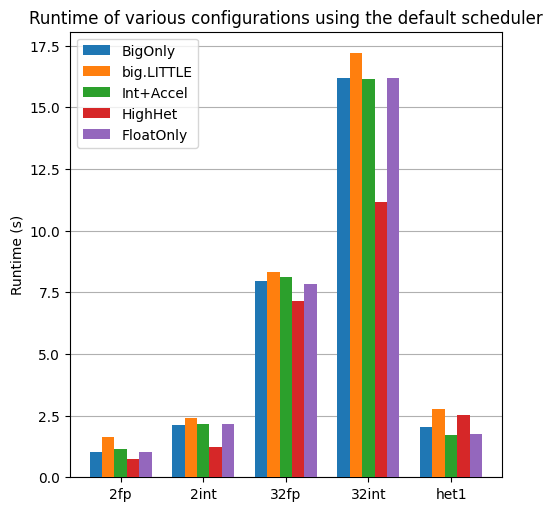

In [32]:
# Compare the performance of the different system configurations on the various benchmarks

benchmarks = [
    "2fp",
    "2int",
    "32fp",
    "32int",
    "het1",
    # "2fp-us",
    # "2int-us",
    # "32fp-us",
    # "32int-us",
    # "het1-us",
]

system_labels = {
    0: "BigOnly",
    1: "big.LITTLE",
    2: "Int+Accel",
    3: "HighHet",
    4: "FloatOnly",
}

bars = {
    system_labels[i]: tuple(
        test_stats[testname].runtime
        for testname in [
            f"sys.{i}-{benchmark}-m5out" for benchmark in benchmarks
        ]
    )
    for i in system_labels
}

print(bars)

x = np.arange(len(benchmarks))
width = 0.15
multiplier = 0

plt.rcParams["figure.figsize"] = (5,5)

fig, ax = plt.subplots(layout="constrained")
for benchmark, perfs in bars.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, perfs, width, label=benchmark, zorder=3)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Runtime (s)")
ax.set_title("Runtime of various configurations using the default scheduler")
ax.set_xticks(x + 2 * width, benchmarks)
ax.legend(loc="upper left", ncols=1)

ax.grid(visible=True, axis='y', zorder=0)

plt.savefig('runtimes.pdf', bbox_inches='tight')

In [15]:
# testname = "sys.4-32fp-us-m5out"
# testname = "sys.0-32fp-us-m5out"
# testname = "sys.3-32fp-us-m5out"
# testname = "sys.4-32int-us-m5out"
# testname = "sys.2-32int-us-m5out"

# testname = "sys.4-2fp-m5out"
testname = "sys.0-2fp-m5out"

stat = test_stats[testname]

max_timestamp = max(
    [stat.cpu_residents[i][-1]["timestamp"] for i in range(stat.num_cpus)]
)

min_timestamp = min(
    [stat.cpu_residents[i][0]["timestamp"] for i in range(stat.num_cpus)]
)

print(f"Execution time: {max_timestamp - min_timestamp}")

Execution time: 1.0298429999999996


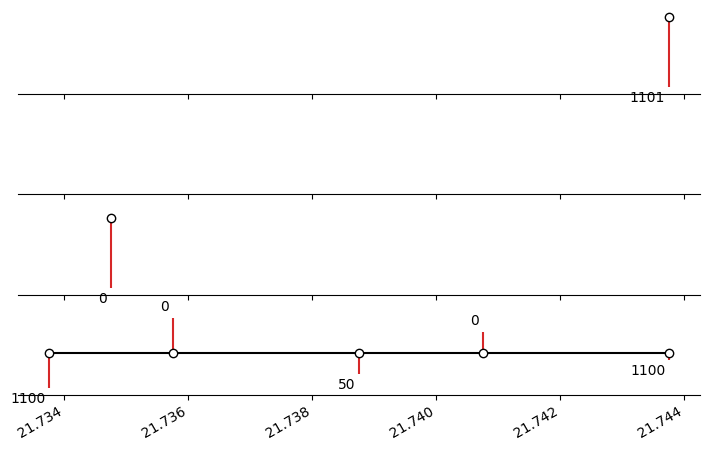

In [16]:
fig, axs = plt.subplots(
    stat.num_cpus, 1, figsize=(8.8, 5), constrained_layout=False, sharex=True
)

# Start the visual partway through the experiment so we can see some steady-state sort of behavior
# start_timestamp = (max_timestamp + min_timestamp) / 2 # seconds
start_timestamp = 0
occupants = {}
for cpu in stat.cpu_occupants:
    occupants[cpu] = []
    for datapoint in stat.cpu_occupants[cpu]:
        if datapoint["timestamp"] > start_timestamp:
            occupants[cpu].append(datapoint)

# Limit the number of datapoints that we show from each core's trace.
num_data_points = 200
max_timestamp = min(
    [
        occupants[cpu][:num_data_points][-1]["timestamp"]
        for cpu in occupants
    ]
)

for cpu in occupants:
    max_index = 0
    while occupants[cpu][max_index]["timestamp"] < max_timestamp:
        max_index += 1

    timeline_data = occupants[cpu][:max_index]

    # Choose some nice levels
    levels = np.tile(
        [-5, 5, -3, 3, -1, 1], int(np.ceil(len(timeline_data) / 6))
    )[: len(timeline_data)]

    # Create figure and plot a stem plot with the date
    # fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
    ax = axs[cpu]

    times = [x["timestamp"] for x in timeline_data]
    pids = [x["pid"] for x in timeline_data]

    ax.vlines(times, 0, levels, color="tab:red")  # The vertical stems.
    ax.plot(
        times, np.zeros_like(times), "-o", color="k", markerfacecolor="w"
    )  # Baseline and markers on it.

    # annotate lines
    for d, l, r in zip(times, levels, pids):
        ax.annotate(
            r,
            xy=(d, l),
            xytext=(-3, np.sign(l) * 3),
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom" if l > 0 else "top",
        )

    # format xaxis with 4 month intervals
    # ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)

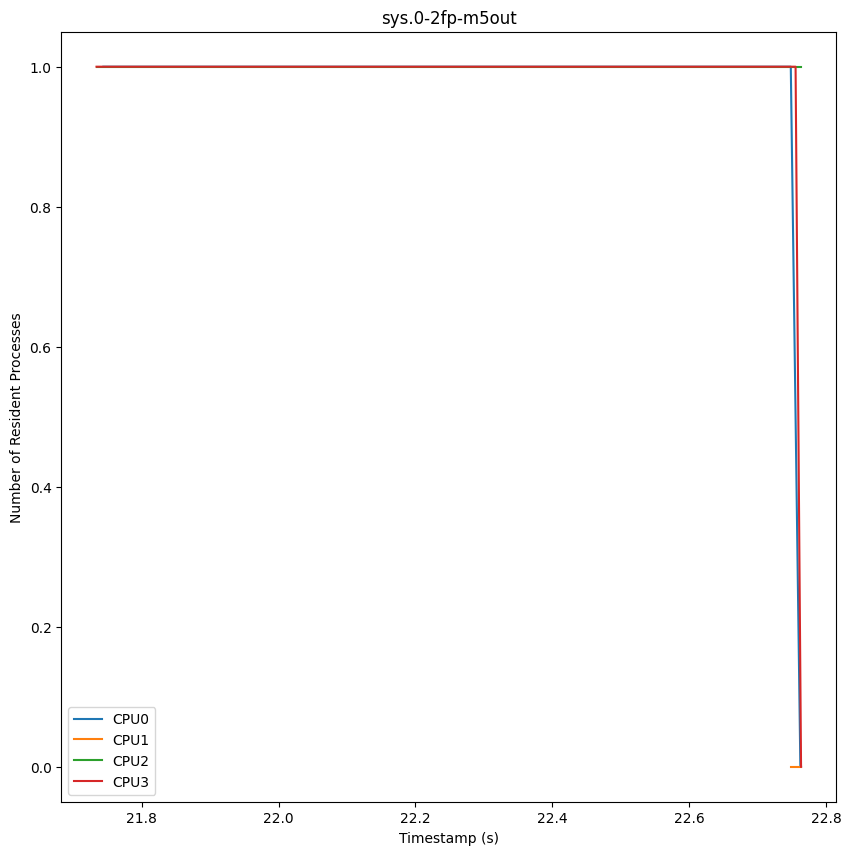

In [17]:
# Calculate the number of processes on each processor at each point in time
num_residents = []
max_timestamp = max(
    [stat.cpu_residents[i][-1]["timestamp"] for i in range(stat.num_cpus)]
)

plt.rcParams["figure.figsize"] = (10,10)

for i in range(stat.num_cpus):
    num_residents.append(([], []))

    for datapoint in stat.cpu_residents[i]:
        num_residents[i][0].append(datapoint["timestamp"])
        num_residents[i][1].append(
            len({pid for pid in datapoint["set"] if pid > 1000})
        )

    num_residents[i][0].append(max_timestamp)
    num_residents[i][1].append(num_residents[i][1][-1])

    plt.plot(num_residents[i][0], num_residents[i][1], label=f"CPU{i}")

plt.title(testname)
plt.xlabel("Timestamp (s)")
plt.ylabel("Number of Resident Processes")
plt.legend()

0.019999999999988916 0.0019999999999988916 0.1
0.019999999999988916 0.0029990000000026384 0.1
0.019999999999988916 0.0019999999999988916 0.1
0.019999999999988916 0.0029989999999990857 0.1
0.920020000000008 0.09000200000000191 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
0.0 0.0990000000000002 0.1
0.0 0.10000000000000142 0.1
0.0 0.10000000000000142 0.1
0.0 0.10000000000000142 0.1
0.0 0.10000000000000142 0.1
0.0 0.10000000000000142 0.1
0.0 0.10000000000000142 0.1
0.0 0.10000000000000142 0.1
0.0 0.10000000000000142 0.1
0.9000200000000191 0.09000200000000191 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0000000000000142 0.10000000000000142 0.1
1.0

IndexError: list index out of range

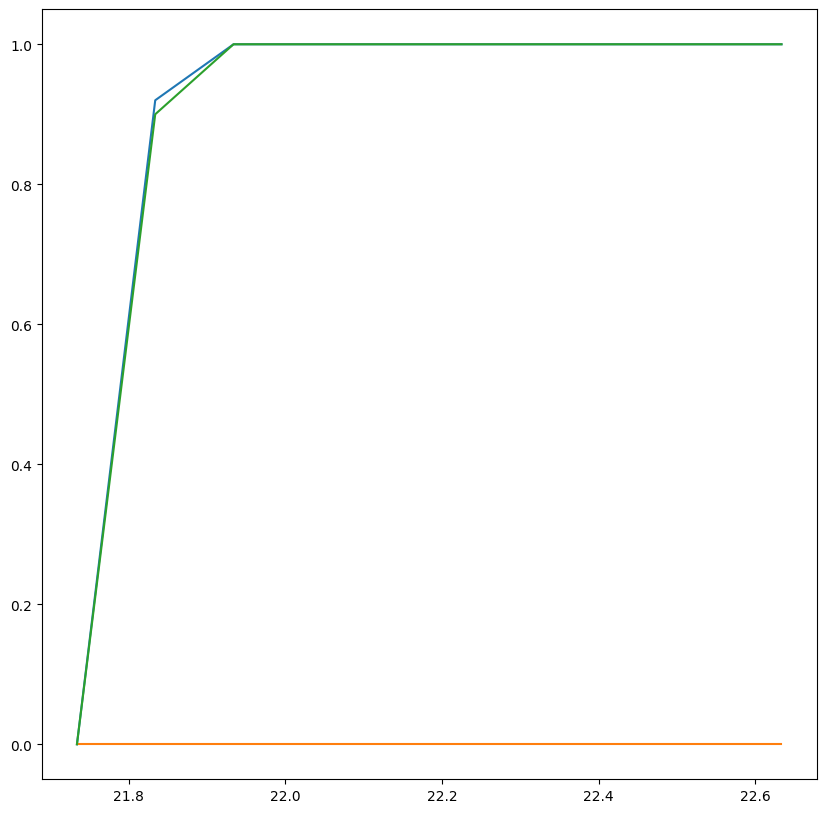

In [21]:
# Calculate the load on each processor
# We're just going to do this by converting anything that isn't the
# idle task to a '1' and converting the idle to a '0'. Then, we're
# going to use a moving average filter.

# Calculate the number of processes on each processor at each point in time
loads = {}
max_timestamp = max(
    [stat.cpu_residents[i][-1]["timestamp"] for i in range(stat.num_cpus)]
)
min_timestamp = min(
    [stat.cpu_residents[i][0]["timestamp"] for i in range(stat.num_cpus)]
)

filter_size = 0.1
time_steps = np.arange(min_timestamp, max_timestamp, filter_size)

plt.rcParams["figure.figsize"] = (10, 10)

for i in stat.cpu_occupants:
    loads[i] = {"times": [], "data": []}

    # convert the data to "loaded" or "not loaded"
    for datapoint in stat.cpu_occupants[i]:
        loads[i]["times"].append(datapoint["timestamp"])
        loads[i]["data"].append(0 if datapoint["pid"] < 1000 else 1)

    # average
    avg_loads = []
    prior_index = 0
    for j in range(len(time_steps) - 1):
        if j == 0:
            avg_loads.append(0)
        else:
            next_index = prior_index
            load = 0
            while (
                next_index < len(loads[i]["times"]) - 1
                and loads[i]["times"][next_index] < time_steps[j]
            ):
                step_length = min(
                    loads[i]["times"][next_index + 1],
                    time_steps[j],
                ) - max(loads[i]["times"][next_index], time_steps[j - 1])

                load += (
                    loads[i]["data"][next_index] * step_length / filter_size
                )

                print(load, step_length, filter_size)

                next_index += 1

            prior_index = next_index - 1

            avg_loads.append(load)

    loads[i]["data"] = avg_loads
    loads[i]["times"] = time_steps[:-1]

    plt.plot(loads[i]["times"], loads[i]["data"], label=f"CPU{i}")

plt.title(testname)
plt.xlabel("Timestamp (s)")
plt.ylabel("Processor Load")
plt.legend()